In [3]:
# 1) import modules

import numpy as np
import pandas as pd
import openpyxl

from get_regression_coefs_general import get_regression_coefs # import our function to get GDP trend
# For plotting
import matplotlib.pyplot as plt
# import seaborn as sns # (not essential)
# sns.set_theme('talk', style = 'white')

In [4]:
# 2.1) Load dataset
data = pd.read_excel('pwt100.xlsx', sheet_name = 'Data', header = 0, engine='openpyxl')

# 2.2) Clean data
# Subseting relevant columns and compute per capita real GDP
data = data.loc[:, ("country", "year", "rgdpe", "pop")]
data["rgdpe_pc"] = data["rgdpe"] / data["pop"]

# select our country (India)
data = data.loc[data["country"] == "India", ("year", "rgdpe_pc")]
# Reset the index (not crucial)
data = data.reset_index(drop = True)

# Subset the RGDP per capita series
ymax = 2019
ymin = 1950
# We use logical indexing to subset the data to rows of years ymin <= year <= ymax
Y = data.loc[np.logical_and(data["year"] <= ymax, data["year"] >= ymin), "rgdpe_pc"]
y = np.log(Y)
data = data[data["year"] >= ymin] # we keep only years after ymin

# Compute separate sample sizes for the subsample used for estimation and the whole sample.
T = len(Y) # sample size used for regression
T_all = data["year"].max() - (ymin - 1) # number of all years in the data after ymin

Text(0.5, 1.0, 'Linear Additive: GDP & trend')

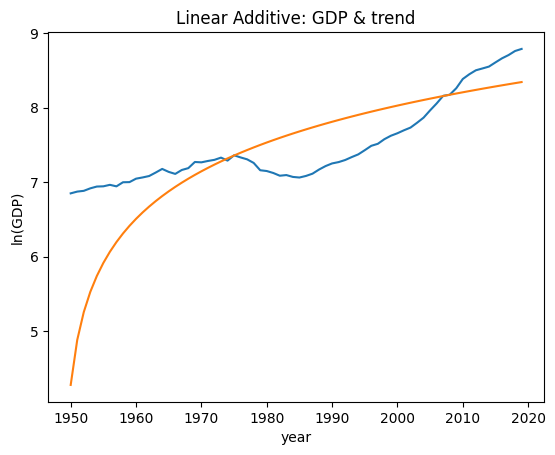

In [5]:
# 3.1) Additive Linear Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
# The dependent variable is per capita GDP in *levels*

x1 = np.empty(T) # initialise an empty vector for the first regressor
x2 = np.empty(T) # initialise an empty vector for the second regressor

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1 # recall that Python starts indexing at 0

a_add_lin, b_add_lin = get_regression_coefs(Y, x1, x2)

# Initialise predicted values yhat
Yhat_add_lin = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_add_lin[t] = a_add_lin + b_add_lin * (t + 1) # recall that Python indexing starts at 0

# Let us convert into log-units
yhat_add_lin = np.log(Yhat_add_lin)

lw = 4

# since this program has only calculated one of the four trends, it can only plot one. But you have to think carefully
# on how to present the results when you have calculated all four

plt.figure()
#one could add options such as a particular size and use instead
#plt.figure(figsize=(7, 5))
plt.plot(data['year'],np.log(data['rgdpe_pc']))
plt.plot(data['year'],yhat_add_lin)

#labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")

#title
plt.title("Linear Additive: GDP & trend")

Text(0.5, 1.0, 'Additive Quadratic Model: GDP & Trend')

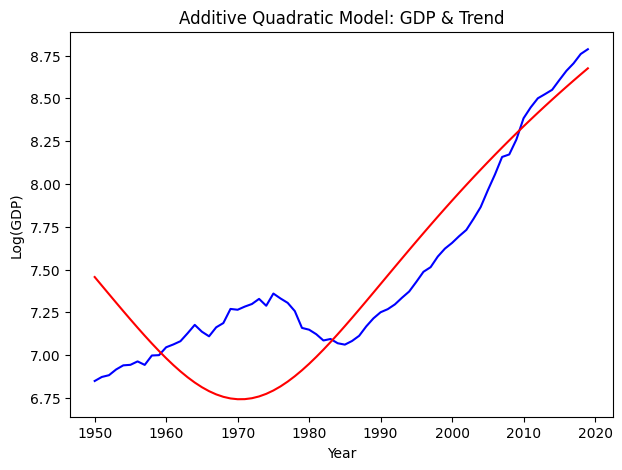

In [6]:
# 3.2) Additive Quadratic Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
# Third regressor x3 is the vector 1^2, 2^2, ..., T^2
x1 = np.empty(T)  # Initialize an empty vector for the first regressor (ones)
x2 = np.empty(T)  # Initialize an empty vector for the second regressor (t)
x3 = np.empty(T)  # Initialize an empty vector for the third regressor (t^2)

for t in range(T):
    x1[t] = 1.  # Vector of ones (intercept)
    x2[t] = t + 1  # Time variable (1, 2, ..., T)
    x3[t] = (t + 1) ** 2  # Time squared variable (1^2, 2^2, ..., T^2)

# Run the regression for the additive quadratic model (GDP ~ t + t^2)
a_add_quad, b_add_quad_t, b_add_quad_t2 = get_regression_coefs(Y, x1, x2, x3)

# Initialize predicted values yhat
Yhat_add_quad = np.empty(T_all)

# Compute the predicted trend for all years
for t in range(T_all):
    Yhat_add_quad[t] = a_add_quad + b_add_quad_t * (t + 1) + b_add_quad_t2 * (t + 1)**2

# Let us convert the trend into log-units
yhat_add_quad = np.log(Yhat_add_quad)

# Plot the actual data and the predicted trend
plt.figure(figsize=(7, 5))
plt.plot(data['year'], np.log(data['rgdpe_pc']), label="Log(GDP) Actual", color='blue')
plt.plot(data['year'], yhat_add_quad, label="Log(GDP) Trend (Additive Quadratic)", color='red')

# Labels
plt.xlabel("Year")
plt.ylabel("Log(GDP)")

# Title
plt.title("Additive Quadratic Model: GDP & Trend")

Text(0.5, 1.0, 'Exponential + Linear Model: GDP & Trend')

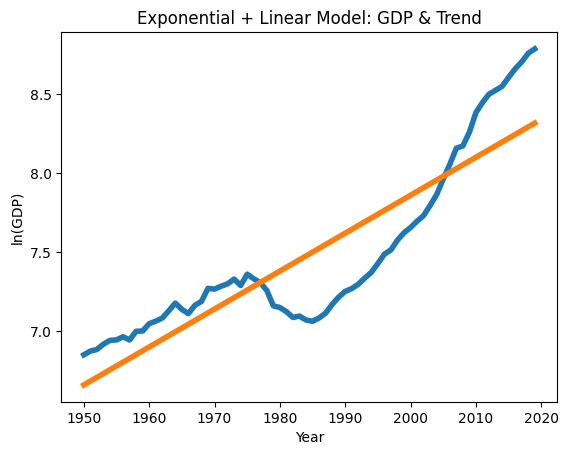

In [7]:
# 3.3) Exponential + Linear Model
# The dependent variable is ln(GDP), which corresponds to exponential growth of GDP.

# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
x1 = np.empty(T)  # initialize an empty vector for the first regressor
x2 = np.empty(T)  # initialize an empty vector for the second regressor

for t in range(T):
    x1[t] = 1.0
    x2[t] = t + 1  # recall Python starts indexing at 0

# Use the log of GDP as the dependent variable (ln(GDP))
ln_Y = np.log(Y)

# Get coefficients for the exponential + linear model
a_exp_lin, b_exp_lin = get_regression_coefs(ln_Y, x1, x2)

# Initialize predicted values ln_yhat for all years
ln_Yhat_exp_lin = np.empty(T_all)

# Compute predicted trend for all years using the model ln(Y) = a + b*t
for t in range(T_all):
    ln_Yhat_exp_lin[t] = a_exp_lin + b_exp_lin * (t + 1)  # recall Python indexing starts at 0

# Convert predicted values from log-units back to levels (GDP)
Yhat_exp_lin = np.exp(ln_Yhat_exp_lin)

# Plot the results
plt.figure()
plt.plot(data["year"], np.log(data["rgdpe_pc"]), label="Observed ln(GDP)", linewidth=lw)
plt.plot(data["year"], np.log(Yhat_exp_lin), label="Trend (Exponential + Linear)", linewidth=lw)

# Labels and title
plt.xlabel("Year")
plt.ylabel("ln(GDP)")
plt.title("Exponential + Linear Model: GDP & Trend")

Text(0.5, 1.0, 'Exponential + Quadratic Model: GDP & Trend')

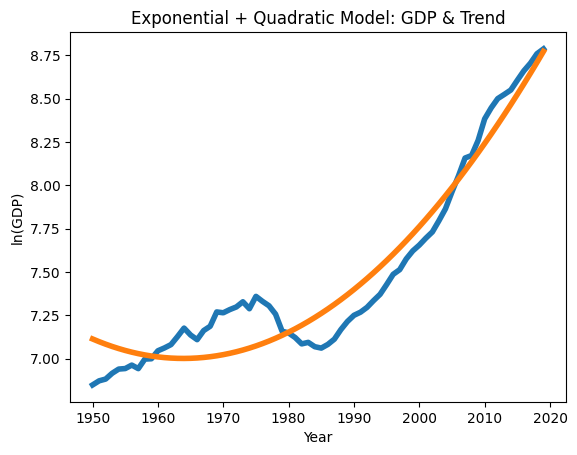

In [8]:
# 3.4) Exponential + Quadratic Model
# The dependent variable is ln(GDP), which corresponds to exponential growth of GDP.

# First regressor x1 is T x 1 vector of ones
# Second regressor x2 is the vector 1, 2, ..., T
# Third regressor x3 is the vector of squared time values: 1^2, 2^2, ..., T^2
x1 = np.empty(T)  # initialize an empty vector for the first regressor
x2 = np.empty(T)  # initialize an empty vector for the second regressor
x3 = np.empty(T)  # initialize an empty vector for the quadratic term

for t in range(T):
    x1[t] = 1.0
    x2[t] = t + 1  # linear time term
    x3[t] = (t + 1) ** 2  # quadratic time term

# Use the log of GDP as the dependent variable (ln(GDP))
ln_Y = np.log(Y)

# Get coefficients for the exponential + quadratic model
a_exp_quad, b_exp_quad, c_exp_quad = get_regression_coefs(ln_Y, x1, x2, x3)

# Initialize predicted values ln_yhat for all years
ln_Yhat_exp_quad = np.empty(T_all)

# Compute predicted trend for all years using the model ln(Y) = a + b*t + c*t^2
for t in range(T_all):
    ln_Yhat_exp_quad[t] = a_exp_quad + b_exp_quad * (t + 1) + c_exp_quad * (t + 1) ** 2

# Convert predicted values from log-units back to levels (GDP)
Yhat_exp_quad = np.exp(ln_Yhat_exp_quad)

# Plot the results
plt.figure()
plt.plot(data["year"], np.log(data["rgdpe_pc"]), label="Observed ln(GDP)", linewidth=4)
plt.plot(data["year"], np.log(Yhat_exp_quad), label="Trend (Exponential + Quadratic)", linewidth=4)

# Labels and title
plt.xlabel("Year")
plt.ylabel("ln(GDP)")
plt.title("Exponential + Quadratic Model: GDP & Trend")